In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from scipy.special import expit
from scipy.optimize import fmin, minimize
import glob as glob
import matplotlib
matplotlib.style.use('ggplot')

# .py
%load_ext autoreload
%autoreload 2
import bounded_alphas, costs, model, weighted_costs, weighted_bounded_alphas

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
all_weather = pd.read_csv("weather01-16.csv")

In [65]:
cm_weather = all_weather[all_weather.stn_name == "Chiang Mai"]
cm_weather.index = pd.DatetimeIndex(cm_weather.date)
mask = (cm_weather.index > "2003") & (cm_weather.index < "2016")
cm_weather = cm_weather[mask]

provinces_df = pd.read_csv("all-dengues.csv")
provinces_df.index = pd.DatetimeIndex(provinces_df.date)
provinces_df = provinces_df.drop(['date','date.1'],axis=1)
cm_dengues = provinces_df[provinces_df['จังหวัด'] == 'ChiangMai'].resample('W').size()
cm_dengues_df = pd.DataFrame(cm_dengues,columns=['cases'])

running model


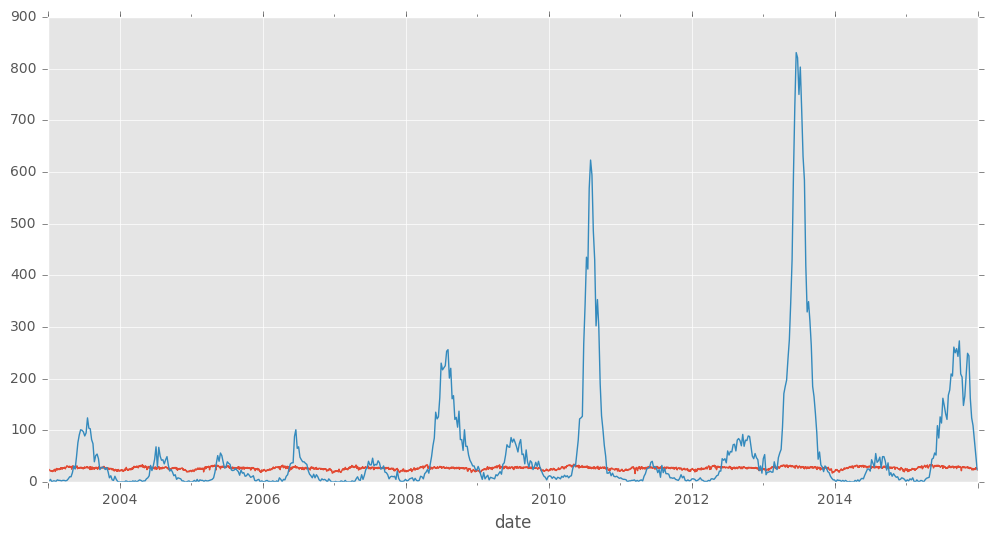

In [71]:
plt.figure(figsize=(12,6))
cm_weather.meantemp.plot()
cm_dengues_df.cases[:-52].plot()

In [67]:
# cm_weather.tail()

In [68]:
cm_avg_weather = cm_weather[['avgrh','dday','maxtemp','meantemp','mintemp','rain']].resample('W').mean()


In [69]:
cm_dengues_weather = pd.concat([cm_avg_weather,cm_dengues_df[:-52]],axis=1)

In [70]:
cm_dengues_weather

,avgrh,dday,maxtemp,meantemp,mintemp,rain,cases
date,,,,,,,
2003-01-05,88.250000,3.500000,26.300000,23.500000,20.750000,3.050000,1
2003-01-12,81.000000,9.000000,27.942857,22.828571,17.757143,0.000000,2
2003-01-19,80.714286,16.000000,27.514286,21.457143,15.400000,0.000000,5
2003-01-26,75.857143,23.000000,27.728571,20.671429,13.700000,0.000000,0
2003-02-02,75.857143,21.142857,29.842857,22.628571,15.500000,0.000000,2
2003-02-09,74.857143,6.000000,28.842857,22.728571,16.685714,0.000000,2
2003-02-16,70.857143,13.000000,32.457143,24.957143,17.514286,0.000000,1
2003-02-23,62.857143,20.000000,32.885714,24.200000,15.585714,0.000000,4
2003-03-02,57.857143,19.000000,34.200000,24.457143,14.742857,0.000000,3


In [80]:
def guess(w,x):
    beta, c = w
    return beta*x + c

def cost(w):
    
    ret = 0
    for i in range(len(cm_dengues_weather.cases)-1):
        real_case = cm_dengues_df[:-52].cases[i+1]
        predicted_case = guess(w,cm_dengues_weather.meantemp[i])
        ret += (real_case - predicted_case)**2
    return ret/float(len(cm_dengues_weather))

w = minimize(cost,[10,-100])

In [81]:
w

      fun: 11463.443607181172
 hess_inv: array([[ 0.00109501, -0.00294253],
       [-0.00294253,  0.06892954]])
      jac: array([ 0.00048828,  0.00024414])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 446
      nit: 17
     njev: 109
   status: 2
  success: False
        x: array([  12.22802574, -270.55940654])

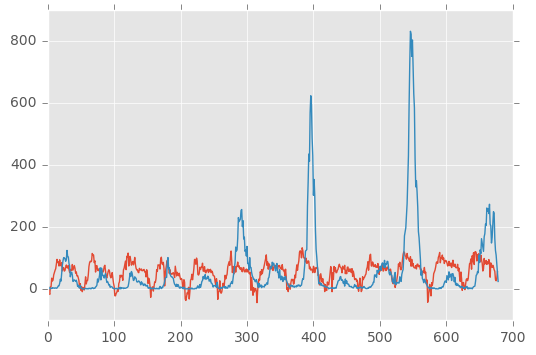

In [89]:
predictions = []
for i in range(len(cm_dengues_weather)-1):
    predicted = guess(w.x,cm_dengues_weather.meantemp[i])
    predictions.append(predicted)

plt.plot(predictions)
plt.plot(range(len(cm_dengues_weather)),cm_dengues_weather.cases)